# Debt Attitudes and Household Borrowing Behavior (SCF 2010-2022)

**Clean Analysis Notebook**

This notebook performs all descriptive and regression analysis for the
writing sample paper. It loads the cleaned dataset produced by
`data_cleaning.py` and generates figures and tables used in the paper.

**Pipeline order:**
1. `data_cleaning.py` — produces `cleaned_scf_data.csv`
2. This notebook — runs analysis and saves outputs
3. `generate_paper_figures.py` — creates publication-quality figures
4. `SeoMinjae_Writing_Sample.qmd` — renders the PDF paper

## 1. Setup and Data Loading

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --------------- Locate project root ---------------
PROJECT_ROOT = None
for p in [Path.cwd(), *Path.cwd().parents]:
    if (p / "output").exists() and (p / "code").exists() and (p / "data").exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError("Could not locate project root (expected output/, code/, data/ dirs).")

DATA_PATH = PROJECT_ROOT / "data" / "clean" / "cleaned_scf_data.csv"
FIGURES_DIR = PROJECT_ROOT / "output" / "figures"
TABLES_DIR = PROJECT_ROOT / "output" / "tables"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# --------------- Load cleaned dataset ---------------
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Cleaned data not found at {DATA_PATH}.\n"
        "Run data_cleaning.py first:  python code/python/data_cleaning.py"
    )

df = pd.read_csv(DATA_PATH)
print(f"Loaded: {len(df):,} observations, {len(df.columns)} variables")
print(f"Years: {sorted(df['YEAR'].unique())}")
print(f"Unique households: {df['YY1'].nunique():,}")

# --------------- Plot settings ---------------
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "font.size": 11,
    "figure.dpi": 120,
    "savefig.dpi": 300,
})
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 200)

Loaded: 86,625 observations, 399 variables
Years: [np.int64(2010), np.int64(2016), np.int64(2022)]
Unique households: 6,555


## 2. Variable Definitions

### Debt-Attitude Variables (from SCF Supplementary Module)

| Variable | Question | Scale | Interpretation |
|----------|----------|-------|----------------|
| `X401` | Is borrowing to buy goods when income is cut a good or bad idea? | 1-5 | 1 = Good idea, 5 = Bad idea |
| `X402` | Is borrowing for a vacation OK? | 1, 5 | 1 = OK, 5 = Not OK |
| `X403` | Is borrowing for living expenses when income is cut OK? | 1, 5 | 1 = OK, 5 = Not OK |
| `X405` | Is borrowing to buy a car OK? | 1, 5 | 1 = OK, 5 = Not OK |

### Key Outcome and Control Variables

| Variable | Description |
|----------|-------------|
| `DEBT_ADJ` | Total household debt (2022 dollars) |
| `LOG_DEBT` | Log-transformed debt: log(1 + DEBT) |
| `INCOME_ADJ` | Total household income (2022 dollars) |
| `LOG_INCOME_ADJ` | Log-transformed income: log(1 + INCOME_ADJ) |
| `NETWORTH` | Household net worth (nominal) |
| `LOG_NETWORTH` | IHS-transformed net worth: arcsinh(NETWORTH) |
| `DEBT2INC` | Debt-to-income ratio |
| `AGE` | Age of household head |
| `EDUC` | Years of education |
| `EDCL` | Education category (1-4): 1=No HS, 2=HS, 3=Some college, 4=College+ |
| `COLLEGE` | Binary: 1 if EDCL >= 4 (bachelor's degree or higher) |
| `YOUNG` | Binary: 1 if AGE < 40 |
| `WGT` | SCF survey weight |

In [2]:
# Verify key variables exist in the cleaned data
key_vars = [
    'X401', 'X402', 'X403', 'X405',
    'DEBT', 'DEBT_ADJ', 'LOG_DEBT', 'DEBT2INC',
    'INCOME', 'INCOME_ADJ', 'LOG_INCOME_ADJ',
    'NETWORTH', 'LOG_NETWORTH',
    'AGE', 'EDUC', 'EDCL', 'COLLEGE', 'YOUNG',
    'WGT', 'WGT_NORM', 'WGT_SCALED',
]
for var in key_vars:
    status = "present" if var in df.columns else "MISSING"
    print(f"  {var:<20s} {status}")

  X401                 present
  X402                 present
  X403                 present
  X405                 present
  DEBT                 present
  DEBT_ADJ             present
  LOG_DEBT             present
  DEBT2INC             present
  INCOME               present
  INCOME_ADJ           present
  LOG_INCOME_ADJ       present
  NETWORTH             present
  LOG_NETWORTH         present
  AGE                  present
  EDUC                 present
  EDCL                 present
  COLLEGE              present
  YOUNG                present
  WGT                  present
  WGT_NORM             present
  WGT_SCALED           present


## 3. Summary Statistics

In [3]:
# Financial and demographic summary
summary_vars = ['INCOME_ADJ', 'NETWORTH', 'DEBT_ADJ', 'DEBT2INC', 'AGE', 'EDUC']
print("Summary Statistics (Unweighted)")
print("=" * 70)
print(df[summary_vars].describe().round(2))

print("\nMedian Values by Year:")
print(df.groupby('YEAR')[summary_vars].median().round(2))

Summary Statistics (Unweighted)
         INCOME_ADJ      NETWORTH      DEBT_ADJ  DEBT2INC       AGE      EDUC
count  8.662500e+04  8.662500e+04  8.662500e+04  86625.00  86625.00  86625.00
mean   1.276565e+06  1.434760e+07  4.179740e+05      1.40     52.42      9.99
std    1.057442e+07  8.394627e+07  3.330241e+06      8.24     16.15      2.85
min    0.000000e+00 -9.468222e+06  0.000000e+00      0.00     18.00     -1.00
25%    4.656650e+04  2.010000e+04  0.000000e+00      0.00     40.00      8.00
50%    1.005836e+05  2.364000e+05  4.000000e+04      0.40     53.00     10.00
75%    2.392103e+05  1.448224e+06  2.500000e+05      1.60     64.00     12.00
max    6.621756e+08  2.387781e+09  2.236292e+08   1195.62     95.00     14.00

Median Values by Year:
      INCOME_ADJ   NETWORTH  DEBT_ADJ  DEBT2INC   AGE  EDUC
YEAR                                                       
2010   102446.30  169843.16  46923.65      0.45  50.0   9.0
2016   104216.48  232552.09  42117.56      0.39  54.0  10.0
20

In [4]:
# Opinion variable distributions
for var, label in [('X401', 'General debt attitude'),
                   ('X402', 'Vacation borrowing'),
                   ('X403', 'Living-expense borrowing'),
                   ('X405', 'Car borrowing')]:
    print(f"\n{var} - {label}:")
    print(df[var].value_counts().sort_index())


X401 - General debt attitude:
X401
1    21822
3    37187
5    27616
Name: count, dtype: int64

X402 - Vacation borrowing:
X402
1    10305
5    76320
Name: count, dtype: int64

X403 - Living-expense borrowing:
X403
1    46368
5    40257
Name: count, dtype: int64

X405 - Car borrowing:
X405
1    65065
5    21560
Name: count, dtype: int64


## 4. Survey Weights

The SCF oversamples wealthier households. All population-level statistics
use SCF survey weights (`WGT`). Weights were normalized within each year
during data cleaning.

In [5]:
weight_summary = df.groupby('YEAR')['WGT'].agg(
    Sum='sum', Mean='mean', Median='median', Std='std', Min='min', Max='max'
)
print("Weight Summary by Year:")
print(weight_summary.round(2))

Weight Summary by Year:
               Sum     Mean   Median      Std   Min       Max
YEAR                                                         
2010  1.176092e+08  3628.79  3740.90  1916.51  1.86  13659.73
2016  1.259817e+08  4032.70  4254.61  2171.88  2.60  12799.27
2022  1.313064e+08  5715.19  4083.83  4966.43  2.75  28265.28


## 5. Weighted Trends in Debt Attitudes (X401)

We group X401 into three categories:
- **Good idea** (X401 <= 2): Favorable toward borrowing
- **Mixed** (X401 = 3): Neutral
- **Bad idea** (X401 >= 4): Unfavorable toward borrowing

In [6]:
# Compute weighted shares by attitude group and year
def classify_x401(x):
    if pd.isna(x): return np.nan
    if x <= 2: return 'Good idea'
    if x == 3: return 'Mixed'
    return 'Bad idea'

df['X401_GROUP'] = df['X401'].apply(classify_x401)

shares = (
    df.dropna(subset=['X401_GROUP'])
    .groupby(['YEAR', 'X401_GROUP'], as_index=False)['WGT']
    .sum()
    .rename(columns={'WGT': 'wgt_sum'})
)
shares['pct'] = shares['wgt_sum'] / shares.groupby('YEAR')['wgt_sum'].transform('sum') * 100

group_order = ['Good idea', 'Mixed', 'Bad idea']
shares['X401_GROUP'] = pd.Categorical(shares['X401_GROUP'], categories=group_order, ordered=True)
pivot = shares.pivot(index='X401_GROUP', columns='YEAR', values='pct').reindex(group_order)

print("Weighted Attitude Distribution (%)")
print("=" * 55)
print(pivot.round(1))
print()
for grp in group_order:
    change = pivot.loc[grp, 2022] - pivot.loc[grp, 2010]
    print(f"  {grp}: {change:+.1f} pp from 2010 to 2022")

# Save for paper reference
att_table = shares.pivot(index='YEAR', columns='X401_GROUP', values='pct').reindex(columns=group_order)
att_table.to_csv(TABLES_DIR / 'x401_attitude_groups_by_year.csv')

Weighted Attitude Distribution (%)
YEAR        2010  2016  2022
X401_GROUP                  
Good idea   21.9  25.9  26.5
Mixed       42.0  42.4  44.0
Bad idea    36.1  31.7  29.5

  Good idea: +4.6 pp from 2010 to 2022
  Mixed: +2.0 pp from 2010 to 2022
  Bad idea: -6.6 pp from 2010 to 2022


/var/folders/2q/g9b4gn5n1bg_47k6lg5psl200000gn/T/ipykernel_38273/3779973987.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g['X401'], weights=g['WGT']))


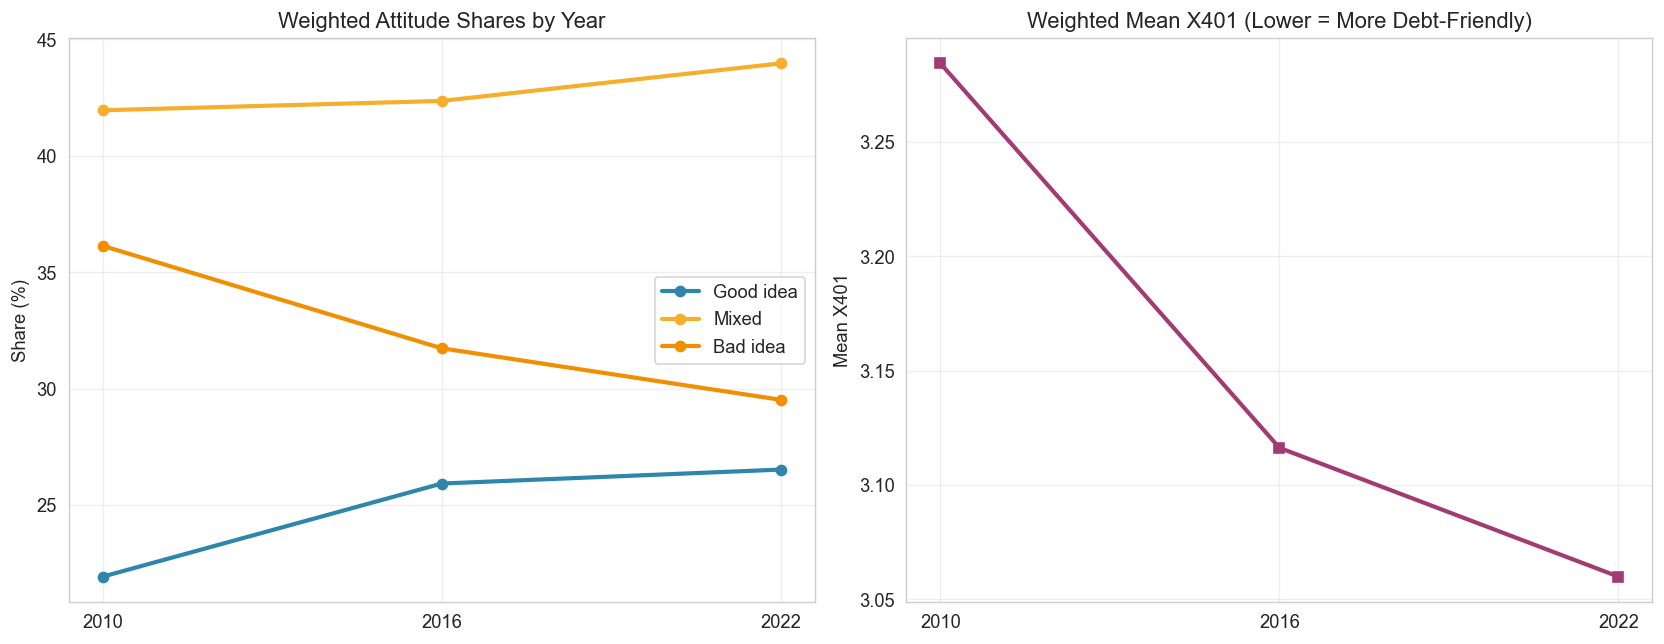

In [7]:
# X401 weighted trend plot
weighted_mean = (
    df.dropna(subset=['X401'])
    .groupby('YEAR')
    .apply(lambda g: np.average(g['X401'], weights=g['WGT']))
    .reset_index(name='mean_x401')
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Left: stacked shares
for grp, color in zip(group_order, ['#2E86AB', '#F6AE2D', '#F18F01']):
    g = shares[shares['X401_GROUP'] == grp].sort_values('YEAR')
    axes[0].plot(g['YEAR'], g['pct'], marker='o', linewidth=2.5, color=color, label=grp)
axes[0].set_title('Weighted Attitude Shares by Year')
axes[0].set_ylabel('Share (%)')
axes[0].set_xticks([2010, 2016, 2022])
axes[0].legend(loc='center right')
axes[0].grid(alpha=0.3)

# Right: weighted mean X401
axes[1].plot(weighted_mean['YEAR'], weighted_mean['mean_x401'],
             marker='s', linewidth=2.5, color='#A23B72')
axes[1].set_title('Weighted Mean X401 (Lower = More Debt-Friendly)')
axes[1].set_ylabel('Mean X401')
axes[1].set_xticks([2010, 2016, 2022])
axes[1].grid(alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'x401_weighted_trend.png', bbox_inches='tight')
plt.show()

## 6. Demographic Heterogeneity

Compare debt-friendly attitudes (X401 <= 2) across age and education
groups. `YOUNG` (age < 40) and `COLLEGE` (EDCL >= 4, i.e. bachelor's
degree or higher) come from the cleaned data.

In [8]:
# Ensure interaction variable exists
if 'YOUNG_COLLEGE' not in df.columns:
    df['YOUNG_COLLEGE'] = df['YOUNG'] * df['COLLEGE']

def favorable_pct(subset):
    """Weighted share with X401 <= 2."""
    fav = subset[subset['X401'] <= 2]['WGT'].sum()
    total = subset['WGT'].sum()
    return (fav / total * 100) if total > 0 else 0

rows = []
for year in [2010, 2016, 2022]:
    y = df[df['YEAR'] == year]
    rows.append({
        'Year': year,
        'Young (<40)': favorable_pct(y[y['YOUNG'] == 1]),
        'Older (40+)':  favorable_pct(y[y['YOUNG'] == 0]),
        'College+':     favorable_pct(y[y['COLLEGE'] == 1]),
        'No College':   favorable_pct(y[y['COLLEGE'] == 0]),
    })
trends = pd.DataFrame(rows)

print("Debt-friendly share (X401 <= 2) by demographic group")
print("=" * 70)
print(trends.round(1))

Debt-friendly share (X401 <= 2) by demographic group
   Year  Young (<40)  Older (40+)  College+  No College
0  2010         22.8         21.5      23.9        21.1
1  2016         30.3         24.2      24.8        26.5
2  2022         31.4         24.6      26.3        26.7


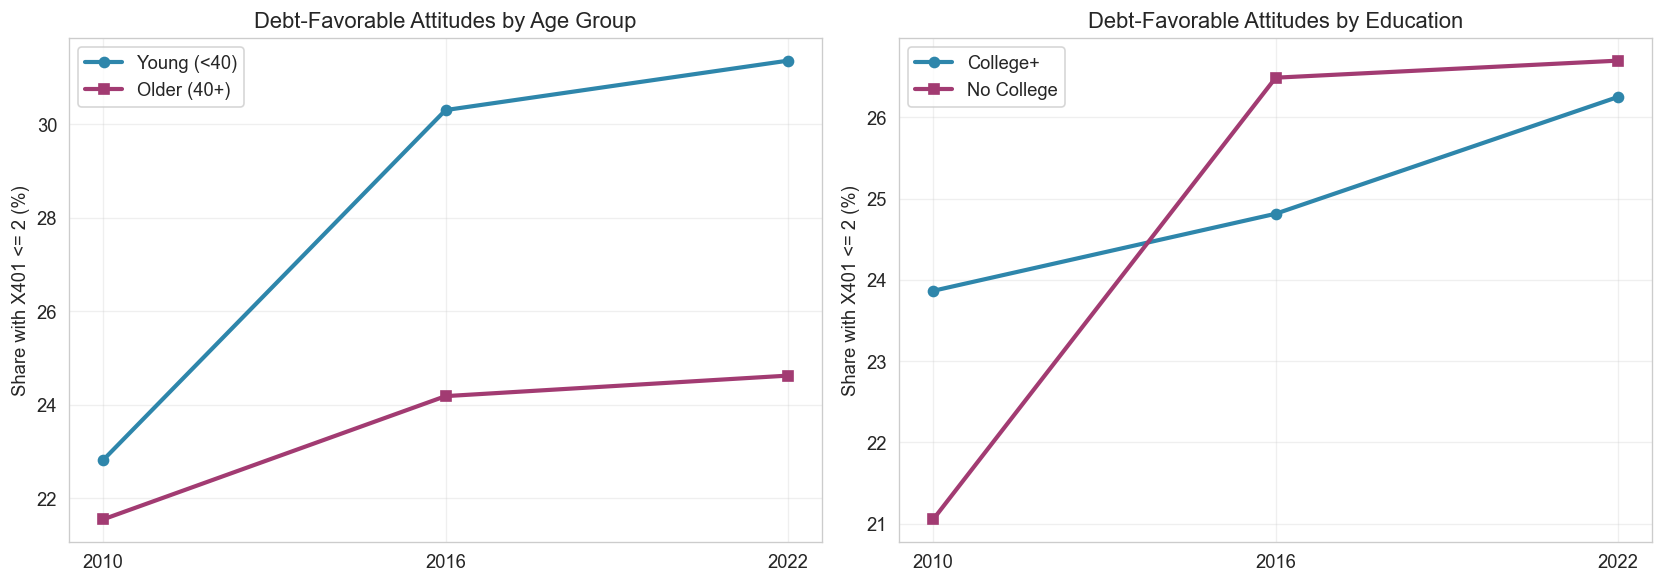

In [9]:
# Demographic trend plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By Age
for grp, col, marker in [('Young (<40)', '#2E86AB', 'o'), ('Older (40+)', '#A23B72', 's')]:
    axes[0].plot(trends['Year'], trends[grp], marker=marker, linewidth=2.5, color=col, label=grp)
axes[0].set_title('Debt-Favorable Attitudes by Age Group')
axes[0].set_ylabel('Share with X401 <= 2 (%)')
axes[0].set_xticks([2010, 2016, 2022])
axes[0].legend()
axes[0].grid(alpha=0.3)

# By Education
for grp, col, marker in [('College+', '#2E86AB', 'o'), ('No College', '#A23B72', 's')]:
    axes[1].plot(trends['Year'], trends[grp], marker=marker, linewidth=2.5, color=col, label=grp)
axes[1].set_title('Debt-Favorable Attitudes by Education')
axes[1].set_ylabel('Share with X401 <= 2 (%)')
axes[1].set_xticks([2010, 2016, 2022])
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Purpose-Specific Borrowing Acceptance

For X402, X403, X405, acceptance is defined as response <= 2.
This reveals whether households distinguish necessity-linked from
discretionary debt.

In [10]:
def acceptance_rate(subset, var):
    accepted = subset[subset[var] <= 2]['WGT'].sum()
    total = subset['WGT'].sum()
    return (accepted / total * 100) if total > 0 else 0

rows = []
for year in [2010, 2016, 2022]:
    y = df[df['YEAR'] == year]
    rows.append({
        'Year': year,
        'Vacation (X402)':         acceptance_rate(y, 'X402'),
        'Living Expenses (X403)':  acceptance_rate(y, 'X403'),
        'Car (X405)':              acceptance_rate(y, 'X405'),
    })
accept = pd.DataFrame(rows)

print("Acceptance Rates by Borrowing Purpose (weighted, X <= 2)")
print("=" * 60)
print(accept.round(1))

# Save for generate_paper_figures.py
purpose_long = []
purpose_map = {
    'Vacation (X402)': ('X402', 'Vacation (Luxury)'),
    'Living Expenses (X403)': ('X403', 'Living expenses (Necessity)'),
    'Car (X405)': ('X405', 'Car purchase (Durable/necessary)'),
}
for year in [2010, 2016, 2022]:
    y = df[df['YEAR'] == year]
    for col, (var, label) in purpose_map.items():
        purpose_long.append({
            'YEAR': year,
            'variable': var,
            'label': label,
            'acceptance_rate': acceptance_rate(y, var) / 100,
        })
pd.DataFrame(purpose_long).to_csv(TABLES_DIR / 'purpose_acceptance_by_year.csv', index=False)

Acceptance Rates by Borrowing Purpose (weighted, X <= 2)
   Year  Vacation (X402)  Living Expenses (X403)  Car (X405)
0  2010             13.9                    50.6        76.9
1  2016             10.3                    56.6        76.3
2  2022             13.0                    63.1        75.7


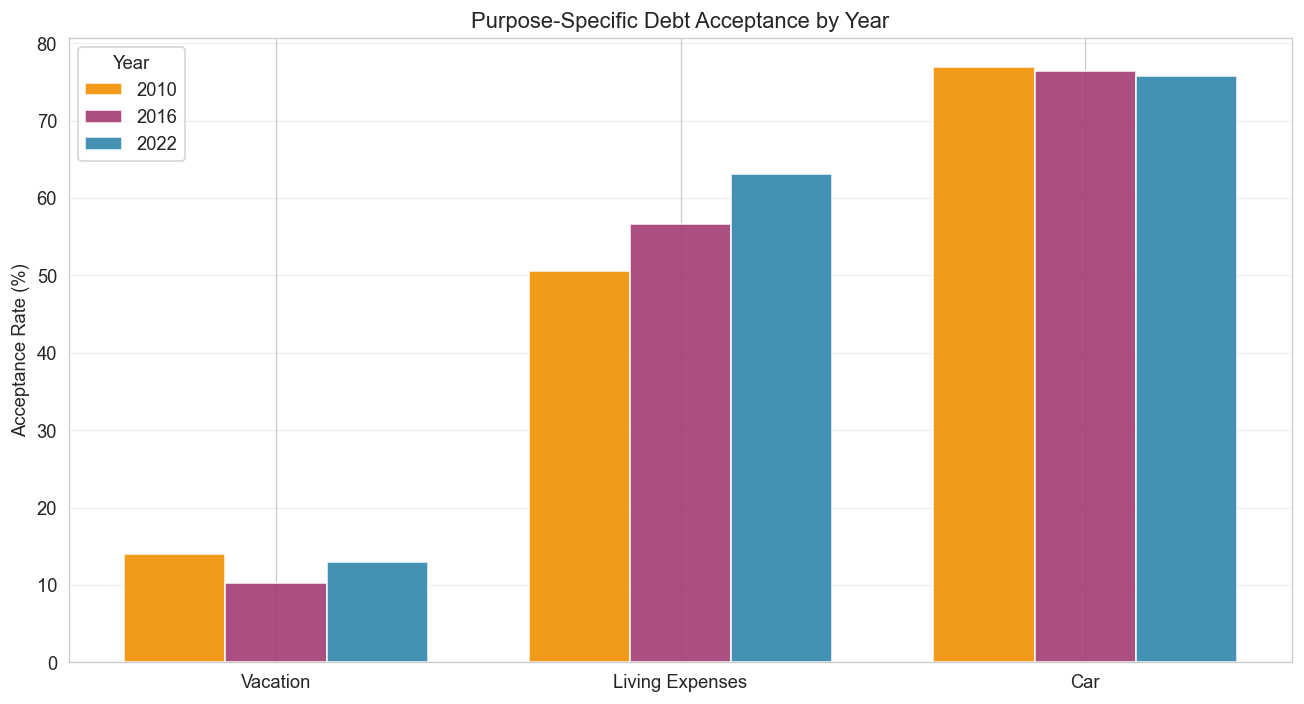

In [11]:
# Purpose acceptance bar chart
fig, ax = plt.subplots(figsize=(11, 6))
x = np.arange(3)
width = 0.25
purposes = ['Vacation (X402)', 'Living Expenses (X403)', 'Car (X405)']
colors = ['#F18F01', '#A23B72', '#2E86AB']

for i, year in enumerate([2010, 2016, 2022]):
    vals = [accept.loc[accept['Year'] == year, p].values[0] for p in purposes]
    ax.bar(x + i * width, vals, width=width, color=colors[i], label=str(year), alpha=0.9)

ax.set_xticks(x + width)
ax.set_xticklabels(['Vacation', 'Living Expenses', 'Car'])
ax.set_ylabel('Acceptance Rate (%)')
ax.set_title('Purpose-Specific Debt Acceptance by Year')
ax.legend(title='Year')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Data Quality Checks

In [12]:
# Missing values
print("Missing Data Summary")
print("=" * 60)
missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing = missing[missing > 0]
if len(missing) > 0:
    print(f"Variables with missing data: {len(missing)}")
    print(missing.head(10).round(2))
else:
    print("No missing data detected.")

# Integrity
print("\nData Integrity")
print("=" * 60)
print(f"Total observations: {len(df):,}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Unique households: {df['YY1'].nunique():,}")
print(f"\nImplicates per household:")
print(df.groupby(['YEAR', 'YY1']).size().value_counts())
print(f"\nObservations by year:")
for year, count in df.groupby('YEAR').size().items():
    print(f"  {int(year)}: {count:,} ({count/len(df)*100:.1f}%)")

Missing Data Summary
No missing data detected.

Data Integrity
Total observations: 86,625


Duplicate rows: 0
Unique households: 6,555

Implicates per household:
5    17325
Name: count, dtype: int64

Observations by year:
  2010: 32,410 (37.4%)
  2016: 31,240 (36.1%)
  2022: 22,975 (26.5%)


## 9. Baseline Regressions

Two benchmark models:
1. **Model 1 (Attitude):** What predicts debt attitudes (X401)?
2. **Model 2 (Behavior):** Do attitudes predict actual debt (LOG_DEBT)?

All models use WLS with SCF survey weights and household-cluster
robust standard errors.

In [13]:
# Regression helper functions
def fit_wls(data, formula, weight_col='WGT_SCALED', cluster_col='HH_CLUSTER'):
    """Fit WLS with cluster-robust standard errors."""
    return smf.wls(formula, data=data, weights=data[weight_col]).fit(
        cov_type='cluster', cov_kwds={'groups': data[cluster_col]}
    )

def tidy(model, model_name):
    """Extract a tidy coefficient table from a fitted model."""
    out = pd.DataFrame({
        'term': model.params.index,
        'coef': model.params.values,
        'std_err': model.bse.values,
        'p_value': model.pvalues.values,
    })
    out['stars'] = np.select(
        [out['p_value'] < 0.01, out['p_value'] < 0.05, out['p_value'] < 0.10],
        ['***', '**', '*'], default=''
    )
    out['coef_se'] = out.apply(
        lambda r: f"{r['coef']:.4f}{r['stars']} ({r['std_err']:.4f})", axis=1
    )
    out['model'] = model_name
    return out

# --------------- Prepare regression data ---------------
reg = df.copy()

# Ensure cluster ID for robust SEs
reg['HH_CLUSTER'] = reg['YEAR'].astype(str) + '_' + reg['YY1'].astype(str)

# Ensure WGT_SCALED exists (mean=1 within each year)
if 'WGT_SCALED' not in reg.columns:
    reg['WGT_SCALED'] = reg.groupby('YEAR')['WGT'].transform(lambda x: x / x.mean())

# --------------- Model 1: Determinants of X401 ---------------
m1_data = reg[['X401','YEAR','LOG_INCOME_ADJ','AGE','EDUC','LOG_NETWORTH',
               'DEBT2INC','WGT_SCALED','HH_CLUSTER']].dropna()
m1_data = m1_data[m1_data['X401'].between(1, 5)]

model1 = fit_wls(m1_data,
    'X401 ~ C(YEAR) + LOG_INCOME_ADJ + AGE + EDUC + LOG_NETWORTH + DEBT2INC')

t1 = tidy(model1, 'X401_main')
t1.to_csv(TABLES_DIR / 'reg_model1_x401_determinants.csv', index=False)

print("=" * 80)
print("MODEL 1: Determinants of Debt Attitude (X401)")
print("=" * 80)
print(f"N = {len(m1_data):,},  R-sq = {model1.rsquared:.4f}")
print(t1[['term', 'coef_se', 'p_value']].to_string(index=False))

y16 = model1.params.get('C(YEAR)[T.2016]', np.nan)
y22 = model1.params.get('C(YEAR)[T.2022]', np.nan)
print(f"\nYear 2016 vs 2010: {y16:.4f} (negative = more debt-friendly)")
print(f"Year 2022 vs 2010: {y22:.4f}")

MODEL 1: Determinants of Debt Attitude (X401)
N = 86,625,  R-sq = 0.0115
           term             coef_se       p_value
      Intercept  3.7187*** (0.1393) 6.656314e-157
C(YEAR)[T.2016] -0.1718*** (0.0301)  1.199562e-08
C(YEAR)[T.2022] -0.2284*** (0.0362)  2.978971e-10
 LOG_INCOME_ADJ -0.0523*** (0.0128)  4.584632e-05
            AGE  0.0058*** (0.0009)  2.610956e-11
           EDUC   -0.0090* (0.0053)  9.115789e-02
   LOG_NETWORTH -0.0059*** (0.0020)  3.176200e-03
       DEBT2INC     0.0011 (0.0023)  6.328835e-01

Year 2016 vs 2010: -0.1718 (negative = more debt-friendly)
Year 2022 vs 2010: -0.2284


## 10. Behavioral Consistency: Do Attitudes Predict Actual Debt?

Regress log real debt on X401 with controls. A negative coefficient means
more debt-friendly attitudes (lower X401) are associated with higher debt.

MODEL 2: Real Debt Holdings on Attitude (LOG_DEBT)
N = 86,625,  R-sq = 0.1698
           term             coef_se      p_value
      Intercept -2.1439*** (0.7121) 2.605684e-03
C(YEAR)[T.2016]     0.0643 (0.0895) 4.725753e-01
C(YEAR)[T.2022]   0.2164** (0.1065) 4.215692e-02
           X401 -0.2003*** (0.0264) 3.316919e-14
 LOG_INCOME_ADJ  1.0520*** (0.0685) 3.512185e-53
            AGE -0.0550*** (0.0027) 2.822879e-91
           EDUC  0.2751*** (0.0182) 1.278149e-51
   LOG_NETWORTH -0.0633*** (0.0046) 6.705420e-43

One-point increase in X401 -> -18.2% change in debt
Move X401=1 to X401=5 -> -55.1% change in debt


/var/folders/2q/g9b4gn5n1bg_47k6lg5psl200000gn/T/ipykernel_38273/1448331955.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.average(g['DEBT_ADJ'], weights=g['WGT_SCALED']))


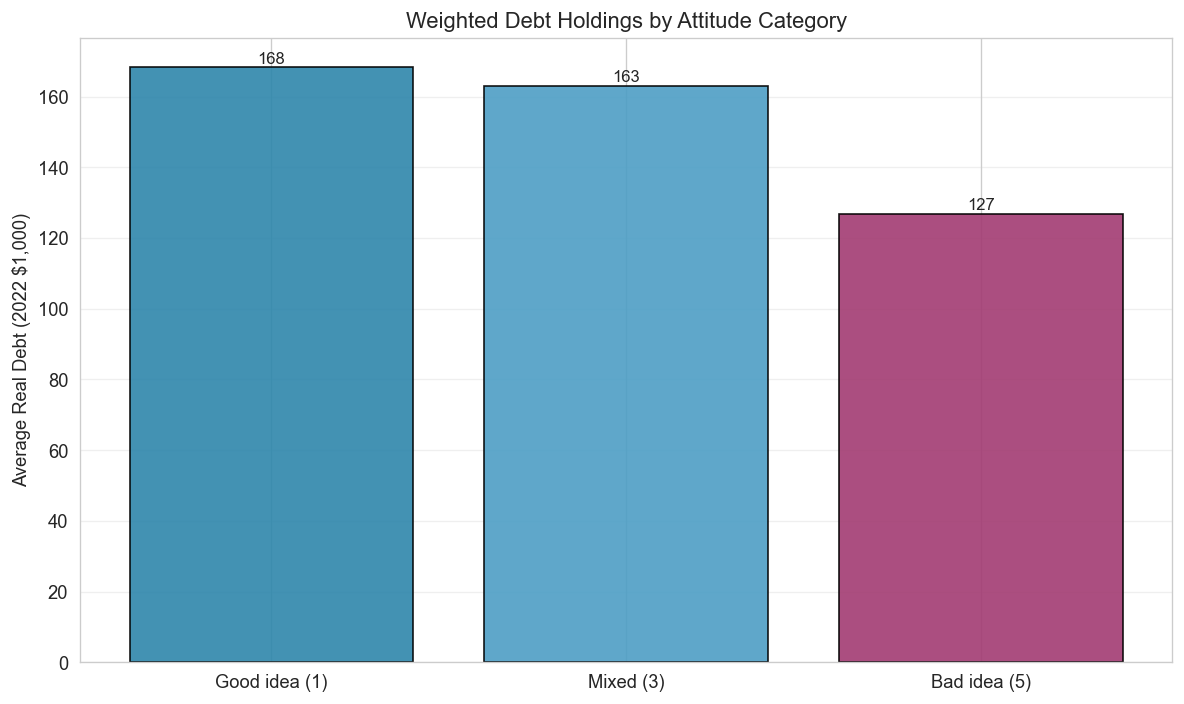

In [14]:
# --------------- Model 2: LOG_DEBT on attitudes ---------------
m2_data = reg[['LOG_DEBT','DEBT_ADJ','X401','YEAR','LOG_INCOME_ADJ',
               'AGE','EDUC','LOG_NETWORTH','WGT_SCALED','HH_CLUSTER']].dropna()
m2_data = m2_data[m2_data['X401'].between(1, 5)]

model2 = fit_wls(m2_data,
    'LOG_DEBT ~ X401 + C(YEAR) + LOG_INCOME_ADJ + AGE + EDUC + LOG_NETWORTH')

t2 = tidy(model2, 'Debt_behavior')
t2.to_csv(TABLES_DIR / 'reg_model2_logdebt_behavior.csv', index=False)

print("=" * 80)
print("MODEL 2: Real Debt Holdings on Attitude (LOG_DEBT)")
print("=" * 80)
print(f"N = {len(m2_data):,},  R-sq = {model2.rsquared:.4f}")
print(t2[['term', 'coef_se', 'p_value']].to_string(index=False))

att_coef = model2.params['X401']
print(f"\nOne-point increase in X401 -> {100*(np.exp(att_coef)-1):.1f}% change in debt")
print(f"Move X401=1 to X401=5 -> {100*(np.exp(att_coef*4)-1):.1f}% change in debt")

# Weighted debt by attitude category (for bar chart)
debt_by_att = (
    m2_data.groupby('X401')
    .apply(lambda g: np.average(g['DEBT_ADJ'], weights=g['WGT_SCALED']))
    .reset_index(name='avg_debt')
    .sort_values('X401')
)

label_map = {1:'Good idea (1)', 2:'Mostly good (2)', 3:'Mixed (3)',
             4:'Mostly bad (4)', 5:'Bad idea (5)'}
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    [label_map[int(x)] for x in debt_by_att['X401']],
    debt_by_att['avg_debt'] / 1000,
    color=['#2E86AB','#4D9EC5','#A23B72','#D97D3E','#F18F01'],
    edgecolor='black', linewidth=1, alpha=0.9,
)
for bar, val in zip(bars, debt_by_att['avg_debt'] / 1000):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()+1.2,
            f'{val:,.0f}', ha='center', fontsize=10)
ax.set_ylabel('Average Real Debt (2022 $1,000)')
ax.set_title('Weighted Debt Holdings by Attitude Category')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'debt_by_attitude_refined.png', bbox_inches='tight')
plt.show()

## 11. Heterogeneity: Age and Education Interactions

**Model 3:** Interact year dummies with YOUNG and COLLEGE to test whether
attitude shifts differ across demographic groups.

**Model 4:** Purpose-specific linear probability models (acceptance = X <= 2).

In [15]:
# --------------- Model 3: Heterogeneous year effects ---------------
m3_data = reg[['X401','YEAR','YOUNG','COLLEGE','LOG_INCOME_ADJ','AGE','EDUC',
               'LOG_NETWORTH','DEBT2INC','WGT_SCALED','HH_CLUSTER',
               'X402','X403','X405']].dropna()
m3_data = m3_data[m3_data['X401'].between(1, 5)]

model3 = fit_wls(m3_data,
    'X401 ~ C(YEAR) * YOUNG + C(YEAR) * COLLEGE + '
    'LOG_INCOME_ADJ + AGE + EDUC + LOG_NETWORTH + DEBT2INC')

t3 = tidy(model3, 'Heterogeneity_joint')
t3.to_csv(TABLES_DIR / 'reg_model3_heterogeneity.csv', index=False)

print("=" * 80)
print("MODEL 3: Heterogeneous Year Effects (Age + Education)")
print("=" * 80)
print(f"N = {len(m3_data):,},  R-sq = {model3.rsquared:.4f}")
key_terms = [t for t in model3.params.index if 'YOUNG' in t or 'COLLEGE' in t or 'YEAR' in t]
print(t3[t3['term'].isin(key_terms)][['term','coef_se','p_value']].to_string(index=False))

# --------------- Model 4: Purpose-specific acceptance ---------------
for v in ['X402', 'X403', 'X405']:
    m3_data[f'{v}_BIN'] = np.where(m3_data[v].between(1,5), (m3_data[v]<=2).astype(float), np.nan)

purpose_models = {
    'X402_BIN': 'Vacation acceptance',
    'X403_BIN': 'Living-expense acceptance',
    'X405_BIN': 'Car-loan acceptance',
}

purpose_results = []
for outcome, label in purpose_models.items():
    tmp = m3_data[[outcome,'X401','YEAR','LOG_INCOME_ADJ','AGE','EDUC',
                    'LOG_NETWORTH','DEBT2INC','WGT_SCALED','HH_CLUSTER']].dropna()
    m = fit_wls(tmp,
        f'{outcome} ~ X401 + C(YEAR) + LOG_INCOME_ADJ + AGE + EDUC + LOG_NETWORTH + DEBT2INC')
    t = tidy(m, label)
    t['outcome'] = outcome
    t['n_obs'] = len(tmp)
    t['r2'] = m.rsquared
    purpose_results.append(t)

purpose_table = pd.concat(purpose_results, ignore_index=True)
purpose_table.to_csv(TABLES_DIR / 'reg_model4_purpose_specific.csv', index=False)

print("\n" + "=" * 80)
print("MODEL 4: Purpose-Specific Acceptance (LPM)")
print("=" * 80)
focus = ['X401', 'C(YEAR)[T.2016]', 'C(YEAR)[T.2022]']
for outcome, label in purpose_models.items():
    sub = purpose_table[(purpose_table['outcome']==outcome) & purpose_table['term'].isin(focus)]
    r2 = purpose_table.loc[purpose_table['outcome']==outcome, 'r2'].iloc[0]
    n = int(purpose_table.loc[purpose_table['outcome']==outcome, 'n_obs'].iloc[0])
    print(f"\n{label} | N={n:,}, R-sq={r2:.4f}")
    print(sub[['term','coef_se','p_value']].to_string(index=False))

MODEL 3: Heterogeneous Year Effects (Age + Education)
N = 86,625,  R-sq = 0.0128
                   term             coef_se  p_value
        C(YEAR)[T.2016] -0.1599*** (0.0423) 0.000160
        C(YEAR)[T.2022] -0.1711*** (0.0517) 0.000939
                  YOUNG     0.0246 (0.0572) 0.666788
  C(YEAR)[T.2016]:YOUNG  -0.1554** (0.0667) 0.019736
  C(YEAR)[T.2022]:YOUNG  -0.2011** (0.0819) 0.014010
                COLLEGE    -0.0921 (0.0586) 0.116027
C(YEAR)[T.2016]:COLLEGE     0.1034 (0.0631) 0.101434
C(YEAR)[T.2022]:COLLEGE     0.0157 (0.0730) 0.829928



MODEL 4: Purpose-Specific Acceptance (LPM)

Vacation acceptance | N=86,625, R-sq=0.0449
           term             coef_se       p_value
C(YEAR)[T.2016] -0.0432*** (0.0064)  1.006478e-11
C(YEAR)[T.2022]  -0.0170** (0.0080)  3.344073e-02
           X401 -0.0425*** (0.0020) 5.620642e-102

Living-expense acceptance | N=86,625, R-sq=0.0775
           term             coef_se      p_value
C(YEAR)[T.2016]  0.0615*** (0.0096) 1.664468e-10
C(YEAR)[T.2022]  0.1327*** (0.0115) 1.357675e-30
           X401 -0.0342*** (0.0029) 9.259279e-33

Car-loan acceptance | N=86,625, R-sq=0.0782
           term             coef_se       p_value
C(YEAR)[T.2016]  -0.0168** (0.0082)  4.034841e-02
C(YEAR)[T.2022] -0.0298*** (0.0099)  2.673095e-03
           X401 -0.0571*** (0.0025) 1.422450e-118


## 12. Export Combined Tables for Paper Figures

Create `regression_main_models.csv` and `regression_heterogeneity.csv`
used by `generate_paper_figures.py`.


In [16]:
# Combine Model 1 and Model 2 into the format expected by generate_paper_figures.py
m1_out = pd.DataFrame({
    'model': 'X401_main',
    'term': model1.params.index,
    'coef': model1.params.values,
    'std_err': model1.bse.values,
    'p_value': model1.pvalues.values,
    'n_obs': len(m1_data),
    'r_squared': model1.rsquared,
})

m2_out = pd.DataFrame({
    'model': 'Debt_behavior',
    'term': model2.params.index,
    'coef': model2.params.values,
    'std_err': model2.bse.values,
    'p_value': model2.pvalues.values,
    'n_obs': len(m2_data),
    'r_squared': model2.rsquared,
})

main_table = pd.concat([m1_out, m2_out], ignore_index=True)
main_table.to_csv(TABLES_DIR / 'regression_main_models.csv', index=False)

# Heterogeneity table
het_out = pd.DataFrame({
    'model': 'Heterogeneity_joint',
    'term': model3.params.index,
    'coef': model3.params.values,
    'std_err': model3.bse.values,
    'p_value': model3.pvalues.values,
    'n_obs': len(m3_data),
    'r_squared': model3.rsquared,
})
het_out.to_csv(TABLES_DIR / 'regression_heterogeneity.csv', index=False)

print("Saved combined tables:")
print(f"  - {TABLES_DIR / 'regression_main_models.csv'}")
print(f"  - {TABLES_DIR / 'regression_heterogeneity.csv'}")
print(f"\nregression_main_models.csv terms for X401_main:")
print(main_table[main_table['model']=='X401_main'][['term','coef','std_err']].to_string(index=False))

Saved combined tables:
  - /Users/seominjae/Desktop/Finance_Sample/output/tables/regression_main_models.csv
  - /Users/seominjae/Desktop/Finance_Sample/output/tables/regression_heterogeneity.csv

regression_main_models.csv terms for X401_main:
           term      coef  std_err
      Intercept  3.718654 0.139343
C(YEAR)[T.2016] -0.171791 0.030140
C(YEAR)[T.2022] -0.228368 0.036250
 LOG_INCOME_ADJ -0.052316 0.012836
            AGE  0.005819 0.000873
           EDUC -0.008994 0.005324
   LOG_NETWORTH -0.005923 0.002008
       DEBT2INC  0.001111 0.002326
